# EfficientNetV2B3

## Description

**Codabench accuracy** : 0.68

**Local test accuracy**: 0.92

**Description**: using a more complex model, combined with more complex augmentation techniques (CutUp Mixup and GridMask)

**Motivation**: To improve generalization capability (even if it worsen a bit locally).

## Google Drive - Connecting to the project

In [1]:
from google.colab import drive
import sys
drive.mount('/content/drive')
project_path = "/content/drive/MyDrive/Colab Notebooks/ANN/le acque del friuli - Homework 1"
%cd {project_path}
sys.path.append(project_path)

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/ANN/le acque del friuli - Homework 1


## Imports

In [2]:
%load_ext autoreload
%autoreload 2
!pip install keras_cv

import utils

import numpy as np
import tensorflow as tf
tfk = tf.keras
tfkl = tfk.layers
import keras_cv

import matplotlib.pyplot as plt

from tensorflow.keras.applications import EfficientNetV2B3
from sklearn.utils.class_weight import compute_class_weight

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 50.2 MB/s eta 0:00:00


## Parameters

In [3]:
# We are dealing with an 8-class problem with 96x96 RGB images as input
OUTPUT_SIZE = 8
INPUT_SHAPE = (96,96,3)
# Batch size defined here since it is needed in the preprocessing
BATCH_SIZE = 64

## Load Data

In [4]:
# Preprocessing parameters
AUTOTUNE = tf.data.AUTOTUNE
NUM_CLASSES = 8

In [5]:
# Defining the augmentation pipeline
augmenter = keras_cv.layers.Augmenter(
    [
    keras_cv.layers.CutMix(),
    keras_cv.layers.MixUp(),
    keras_cv.layers.GridMask(),
    ]
)

# Preprocessing training with one hot encoding and augmentation
def preprocess_train(images, labels):
    labels = tf.one_hot(labels, NUM_CLASSES)
    inputs = {"images": images, "labels": labels}
    outputs = augmenter(inputs)
    return outputs["images"], outputs["labels"]

# Preprocessing test and validation with one hot encoding
def preprocess_test_val(images, labels):
    labels = tf.one_hot(labels, NUM_CLASSES)
    return images, labels

# Converts numpy arrays into tensorflow dataset applying automatic prefetching and setting batch size
def convert_into_dataset(X, y, split=""):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    if split == "train":
        dataset = dataset.shuffle(1024).batch(BATCH_SIZE).prefetch(AUTOTUNE)
    else:
        dataset = dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return dataset

# Visualizes 9 randomly picked samples from a tensorflow dataset
def visualize_dataset(dataset, title):
    plt.figure(figsize=(6, 6))
    plt.suptitle(title, fontsize=18)
    for i, (images, labels) in enumerate(dataset.take(9)):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[0].numpy().astype("uint8"))
        plt.axis("off")
    plt.show()

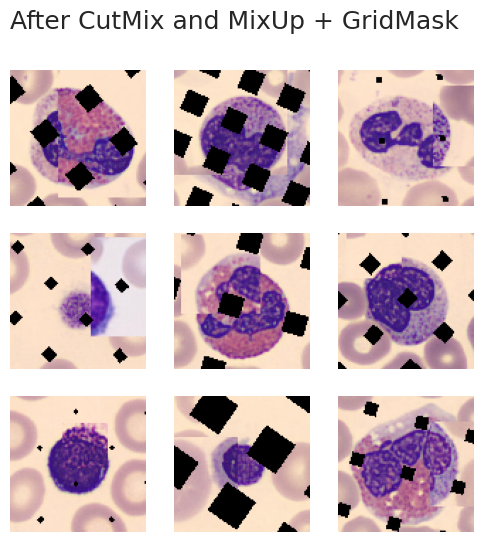

In [6]:
# Loading the dataset
X, y = utils.load_cleaned_dataset()
X_train, X_val, X_test, y_train, y_val, y_test = utils.split_dataset(X, y, test_size=0.1, val_size=0.2)


# Preprocessing training and validation
train_data = convert_into_dataset(X_train, y_train, split="train")
val_data = convert_into_dataset(X_val, y_val)
train_data = train_data.map(preprocess_train, num_parallel_calls=AUTOTUNE)
val_data = val_data.map(preprocess_test_val, num_parallel_calls=AUTOTUNE)

# Visualize the new training dataset with augmentation
visualize_dataset(train_data, title="After CutMix and MixUp + GridMask")

## Model Implementation

In [7]:
# Importing EfficientNetV2B3 without top layers
efficientNet = EfficientNetV2B3(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)
efficientNet.trainable = False

52606240/52606240 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [8]:
# Model definition
def build_model():
    input_layer = tfkl.Input(shape=INPUT_SHAPE, name='Input')

    # Embedded augmentation
    augmentation = tfk.Sequential([
        tfkl.RandomFlip('horizontal_and_vertical'),
        tfkl.RandomRotation(0.2),
        tfkl.RandomTranslation(0.2, 0.2),
        tfkl.RandomContrast(0.3),
        tfkl.RandomBrightness((0.3,0.7))
    ])

    x = augmentation(input_layer)

    # Passing augmented data into the efficientNet
    x = efficientNet(x)

    # GAP layer to reduce size
    x = tfkl.GlobalAveragePooling2D()(x)

    # Simple interleaving of Dense and ELU activation functions
    x = tfkl.Dense(128)(x)
    x = tfkl.ELU()(x)
    x = tfkl.Dense(256)(x)
    x = tfkl.ELU()(x)
    x = tfkl.Dense(256)(x)
    x = tfkl.ELU()(x)
    x = tfkl.Dense(512)(x)
    x = tfkl.ELU()(x)

    # Dropout only on the last layer to reduce overfitting
    x = tfkl.Dropout(0.5)(x)
    output_layer = tfkl.Dense(OUTPUT_SIZE, activation='softmax', dtype='float32', name='Output')(x)

    model = tfk.Model(inputs=input_layer, outputs=output_layer)
    return model

In [9]:
# Custom Learning Rate
LR = 1e-4

In [10]:
# Build the model
model = build_model()

# Compilation with Lion
model.compile(optimizer=tfk.optimizers.Lion(LR),
              loss=tfk.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-b3 (Functional)       │ (None, 3, 3, 1536)          │      12,930,622 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1536)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         196,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ elu (ELU)                            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ elu_1 (ELU)                          │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ elu_2 (ELU)                          │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ elu_3 (ELU)                          │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (None, 8)                   │           4,104 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,361,862 (50.97 MB)

 Trainable params: 431,240 (1.65 MB)

 Non-trainable params: 12,930,622 (49.33 MB)

## Training

In [11]:
# Training parameters
EPOCHS = 1000
PATIENCE = 10

In [12]:
# Early stopping implementation
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)
callbacks = [early_stopping]

In [13]:
# Actual Training
history = model.fit(train_data,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    callbacks=callbacks,
                    validation_data=val_data).history

Epoch 1/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 34s 108ms/step - accuracy: 0.2657 - loss: 1.9368 - val_accuracy: 0.3236 - val_loss: 1.6397
Epoch 2/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - accuracy: 0.3973 - loss: 1.7516 - val_accuracy: 0.5142 - val_loss: 1.4047
Epoch 3/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - accuracy: 0.4285 - loss: 1.7118 - val_accuracy: 0.5142 - val_loss: 1.3255
Epoch 4/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - accuracy: 0.4247 - loss: 1.6963 - val_accuracy: 0.5054 - val_loss: 1.3054
Epoch 5/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.4406 - loss: 1.6749 - val_accuracy: 0.5598 - val_loss: 1.2453
Epoch 6/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - accuracy: 0.4450 - loss: 1.6888 - val_accuracy: 0.5865 - val_loss: 1.2402
Epoch 7/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - accuracy: 0.4324 - loss: 1.6737 - val_accuracy: 0.5393 - val_loss: 1.2321
Epoch 8/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - accuracy: 0.4585 - 

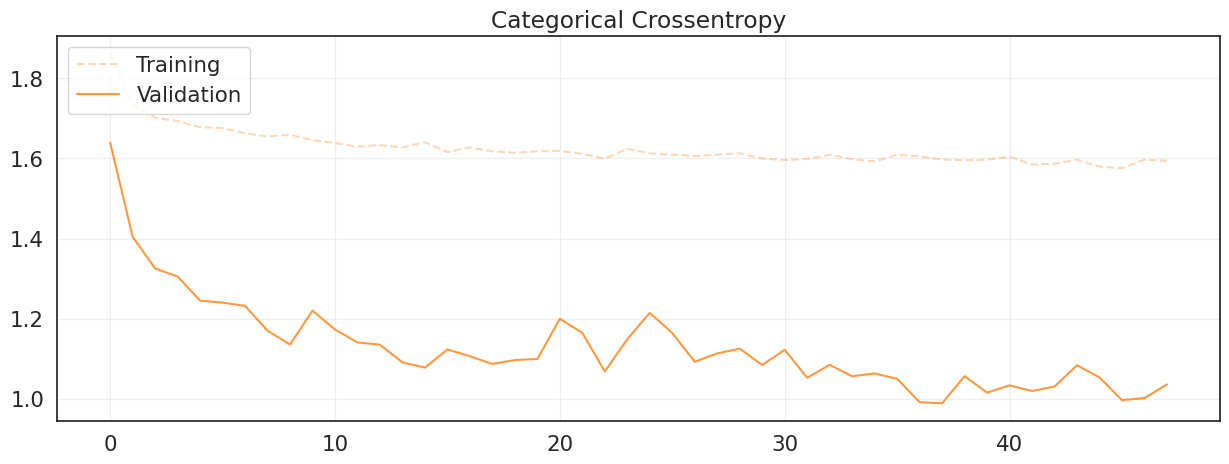

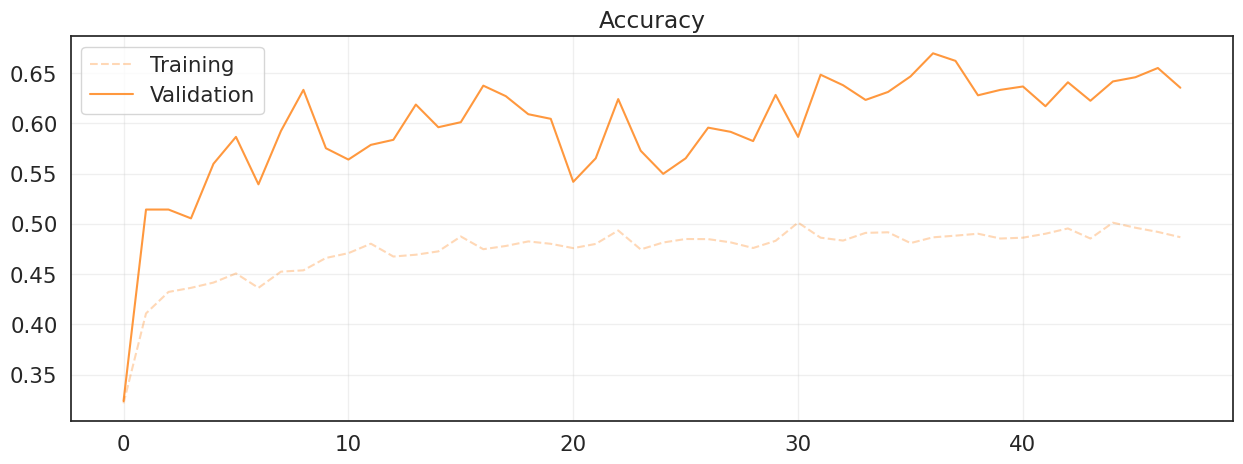

In [14]:
# Plotting loss function and accuracy over epochs
utils.plot_history(history)

## Save

In [15]:
# Saving the model for future testing and submission
accuracy = round(max(history['val_accuracy'])* 100, 2)
model_name = f"efficientnetv2b3_{accuracy}.keras"
%cd models/
print(f"Saving {model_name}")
model.save(model_name)
%cd ..
print("Model Saved")

/content/drive/MyDrive/Colab Notebooks/ANN/le acque del friuli - Homework 1/models
Saving efficientnetv2b3_66.97.keras
/content/drive/MyDrive/Colab Notebooks/ANN/le acque del friuli - Homework 1
Model Saved


## Fine-Tuning


In [16]:
network_name = 'efficientnetv2-b3'

# Setting all the parameters of the network as trainable
model.get_layer(network_name).trainable = True

# Setting all the layers as non trainable
for layer in model.get_layer(network_name).layers:
    layer.trainable = False

# Setting all the actually trainable layers to trainable
for i, layer in enumerate(model.get_layer(network_name).layers):
    if isinstance(layer, tfkl.Conv2D) or isinstance(layer, tfkl.SeparableConv2D) or isinstance(layer, tfkl.DepthwiseConv2D):
        layer.trainable = True

# Freezing up to a certain depth
FREEZE_DEPTH = 60
for layer in model.get_layer(network_name).layers[:FREEZE_DEPTH]:
    layer.trainable = False

# Print model details
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-b3 (Functional)       │ (None, 3, 3, 1536)          │      12,930,622 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1536)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         196,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ elu (ELU)                            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ elu_1 (ELU)                          │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ elu_2 (ELU)                          │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ elu_3 (ELU)                          │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (None, 8)                   │           4,104 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,793,104 (52.62 MB)

 Trainable params: 12,662,510 (48.30 MB)

 Non-trainable params: 699,352 (2.67 MB)

 Optimizer params: 431,242 (1.65 MB)

In [17]:
# Custom FT learning rate
FT_LEARNING_RATE = 1e-5

In [18]:
# New compilation according to the new learning rate
model.compile(optimizer=tfk.optimizers.Lion(FT_LEARNING_RATE),
                loss=tfk.losses.CategoricalCrossentropy(),
                metrics=['accuracy'])

In [19]:
# Training using the same parameters used previously, only LR changes
finetuned_history = model.fit(train_data,
                              epochs=EPOCHS,
                              batch_size=BATCH_SIZE,
                              callbacks=callbacks,
                              validation_data= val_data).history

Epoch 1/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 44s 150ms/step - accuracy: 0.5114 - loss: 1.5687 - val_accuracy: 0.7375 - val_loss: 0.7936
Epoch 2/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 16s 116ms/step - accuracy: 0.5565 - loss: 1.4819 - val_accuracy: 0.7960 - val_loss: 0.7051
Epoch 3/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 16s 116ms/step - accuracy: 0.5855 - loss: 1.4500 - val_accuracy: 0.7860 - val_loss: 0.7364
Epoch 4/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 16s 117ms/step - accuracy: 0.6110 - loss: 1.4107 - val_accuracy: 0.8491 - val_loss: 0.5997
Epoch 5/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 16s 117ms/step - accuracy: 0.6129 - loss: 1.3957 - val_accuracy: 0.8620 - val_loss: 0.5627
Epoch 6/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 16s 116ms/step - accuracy: 0.6159 - loss: 1.3931 - val_accuracy: 0.8625 - val_loss: 0.5825
Epoch 7/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 16s 117ms/step - accuracy: 0.6298 - loss: 1.3647 - val_accuracy: 0.8880 - val_loss: 0.5478
Epoch 8/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 16s 118ms/step - accuracy: 

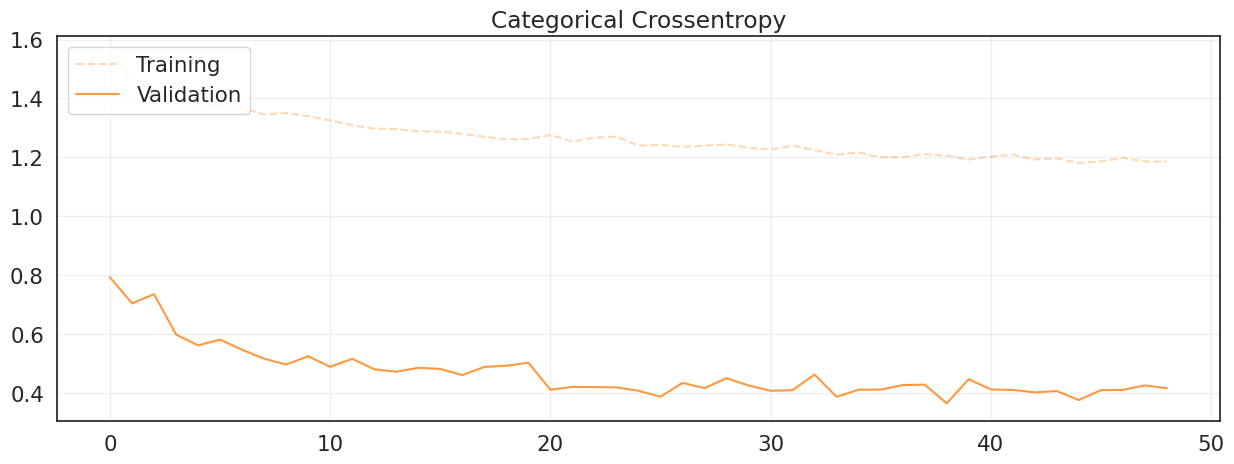

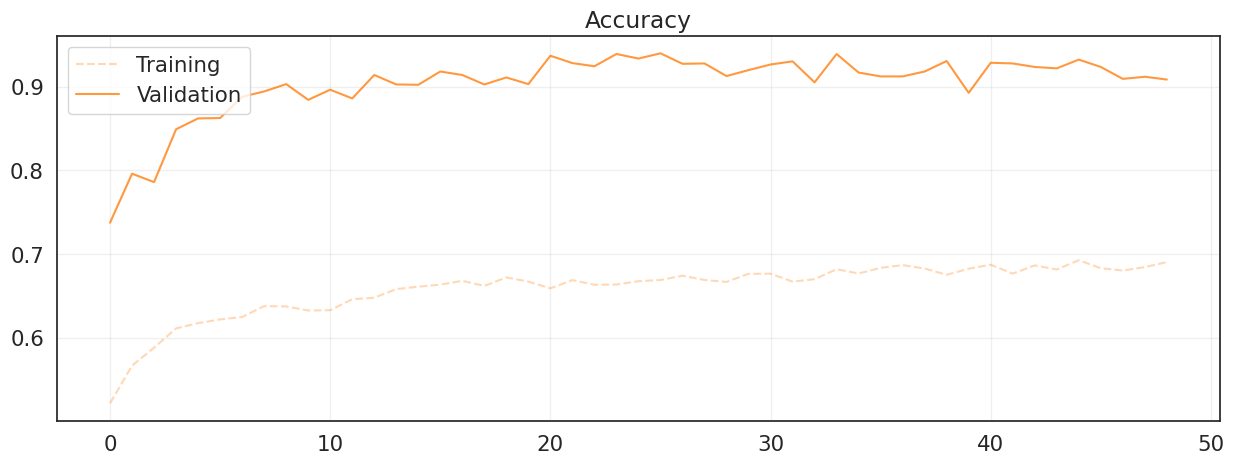

In [20]:
# Plotting the loss function and accuracy value over epochs
utils.plot_history(finetuned_history)

## Saving the model

In [21]:
# Plot the loss function and accuracy value over epochs
accuracy = round(max(finetuned_history['val_accuracy'])* 100, 2)
model_name = f"efficientnetv2b3_{accuracy}.keras"
%cd models/
print(f"Saving {model_name}")
model.save(model_name)
%cd ..
print("Model Saved")

/content/drive/MyDrive/Colab Notebooks/ANN/le acque del friuli - Homework 1/models
Saving efficientnetv2b3_93.98.keras
/content/drive/MyDrive/Colab Notebooks/ANN/le acque del friuli - Homework 1
Model Saved


## Test Prediction and Final Evaluation

In [22]:
# Predict class probabilities and get predicted classes
test_predictions = model.predict(X_test, verbose=0)
test_predictions = np.argmax(test_predictions, axis=1)

In [23]:
# Calculate and display test set accuracy
test_accuracy = accuracy_score(y_test, test_predictions)
print(f'Accuracy score over the test set: {round(test_accuracy, 4)}')

# Calculate and display test set precision
test_precision = precision_score(y_test, test_predictions, average='weighted')
print(f'Precision score over the test set: {round(test_precision, 4)}')

# Calculate and display test set recall
test_recall = recall_score(y_test, test_predictions, average='weighted')
print(f'Recall score over the test set: {round(test_recall, 4)}')

# Calculate and display test set F1 score
test_f1 = f1_score(y_test, test_predictions, average='weighted')
print(f'F1 score over the test set: {round(test_f1, 4)}')

Accuracy score over the test set: 0.9172
Precision score over the test set: 0.9303
Recall score over the test set: 0.9172
F1 score over the test set: 0.9197
